In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pymc as pm
import pymc.sampling_jax
import bambi as bmb
import seaborn as sns
import arviz as az
import networkx as nx
import warnings

warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=Warning)

/Users/corrado/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
%config InlineBackend.figure_format = 'retina'
RANDOM_SEED = 42
rng = np.random.default_rng(RANDOM_SEED)
az.style.use("arviz-darkgrid")
sns.set_theme(palette="colorblind")

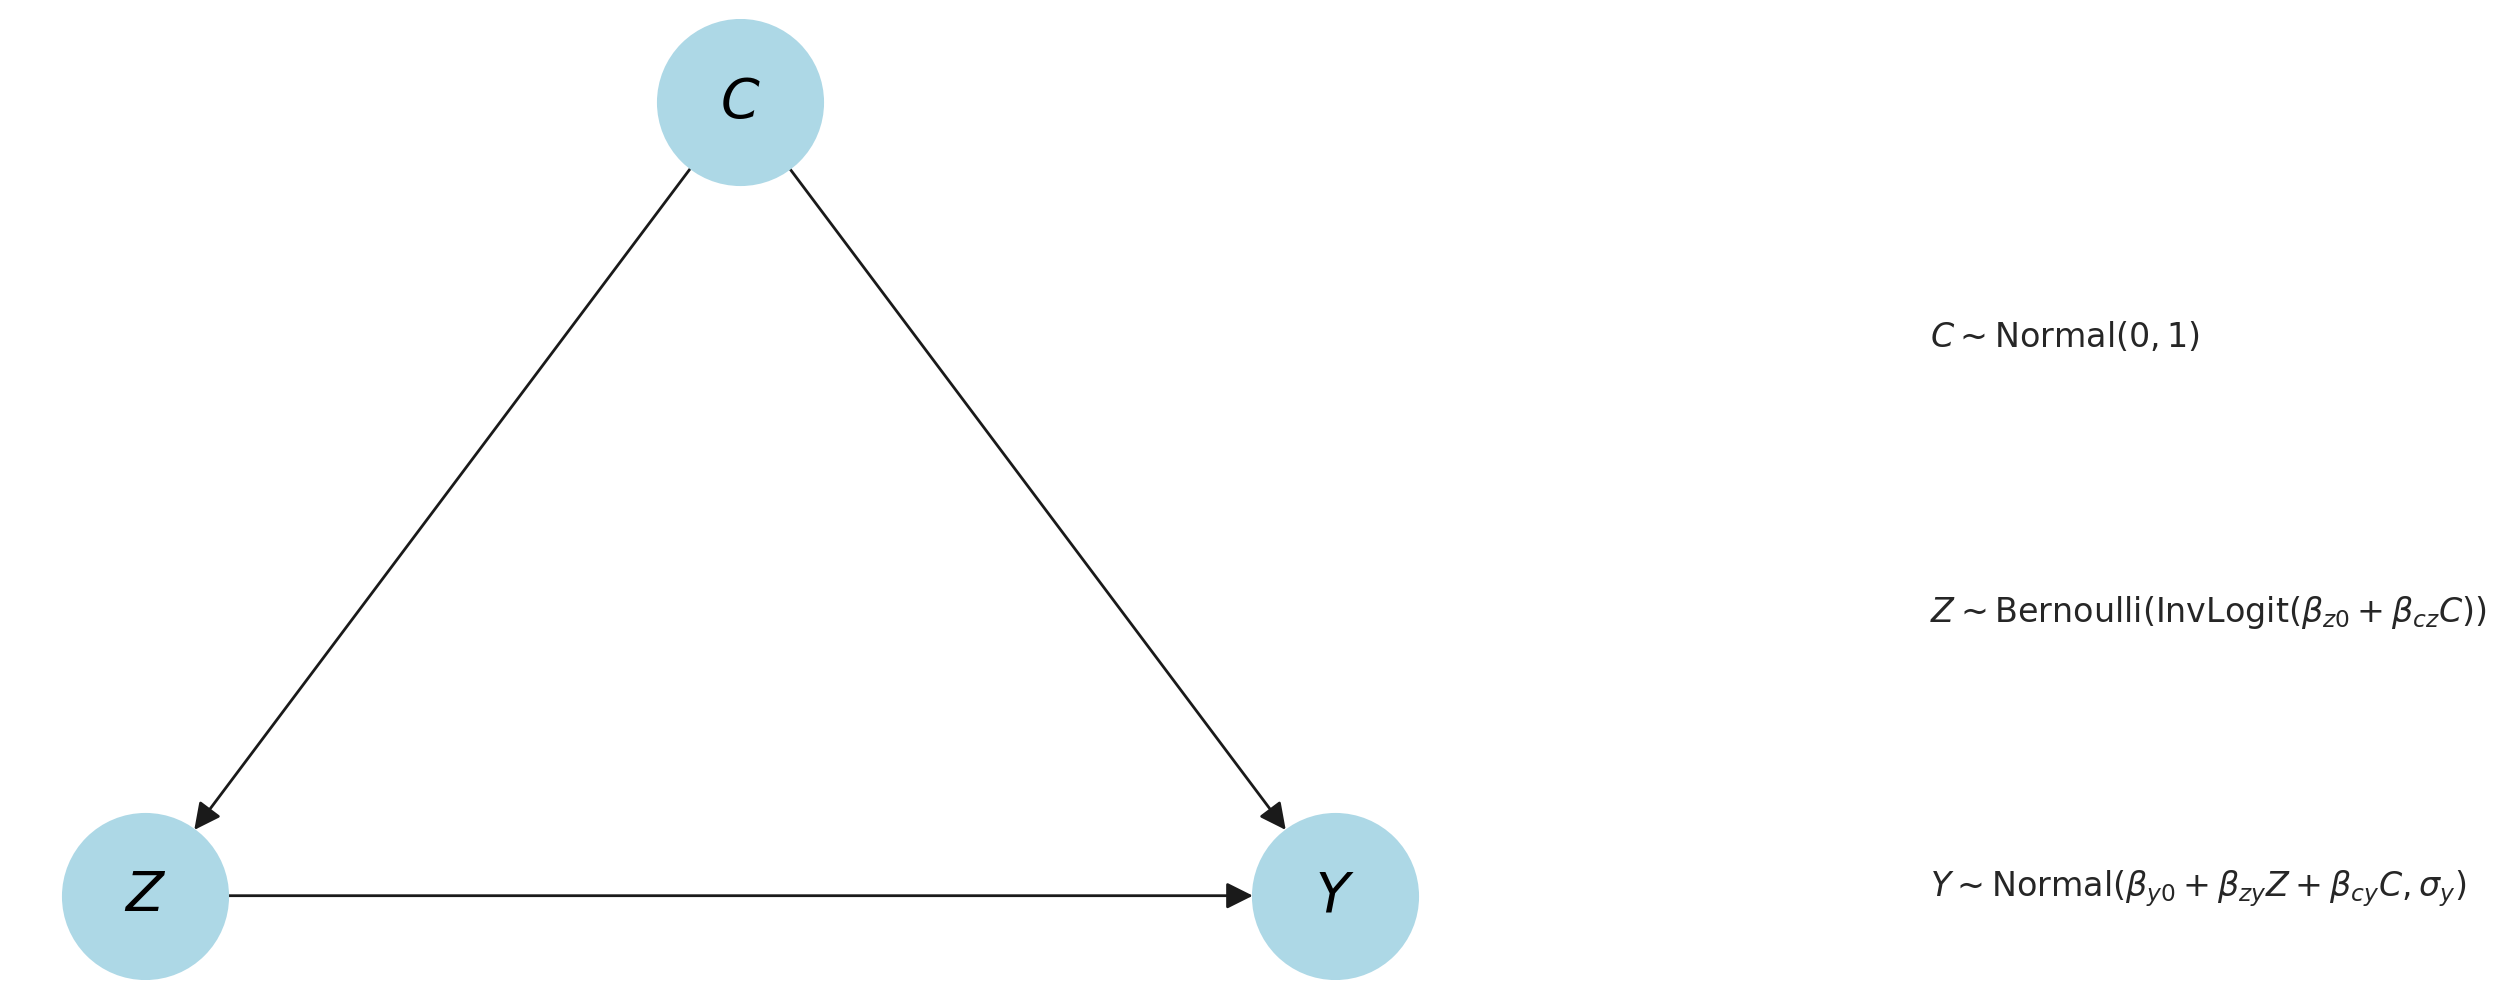

In [3]:
# Initialize a directed graph
g = nx.DiGraph()

# Add nodes
g.add_nodes_from(["Y", "Z", "C"])

# Add edges
g.add_edges_from([("Z", "Y"), ("C", "Y"), ("C", "Z")])

# Draw the graph
pos = {"Y": (0, 0), "Z": (-1, 0), "C": (-0.5, 0.866)}
labels = {"Y": r"$Y$", "Z": r"$Z$", "C": r"$C$"}

# Add edges and nodes to the plot
nx.draw(
    g,
    pos,
    labels=labels,
    with_labels=True,
    node_size=3500,
    node_color="lightblue",
    font_size=20,
    font_color="black",
    font_weight="bold",
    arrowsize=20,
)

# Add text/annotations
plt.text(0.5, 0.6, r"$C \sim \mathrm{Normal}(0, 1)$", fontsize=12)
plt.text(
    0.5,
    0.3,
    r"$Z \sim \mathrm{Bernoulli}(\operatorname{InvLogit}(\beta_{z0} + \beta_{cz} C))$",
    fontsize=12,
)
plt.text(
    0.5,
    0,
    r"$Y \sim \mathrm{Normal}(\beta_{y0} + \beta_{zy} Z + \beta_{cy} C, \sigma_y)$",
    fontsize=12,
)

plt.show()

In [4]:
with pm.Model(coords_mutable={"i": [0]}) as model_generative:
    # priors on Y <- C -> Z
    beta_y0 = pm.Normal("beta_y0")
    beta_cy = pm.Normal("beta_cy")
    beta_cz = pm.Normal("beta_cz")
    # priors on Z -> Y causal path
    beta_z0 = pm.Normal("beta_z0")
    beta_zy = pm.Normal("beta_zy")
    # observation noise on Y
    sigma_y = pm.HalfNormal("sigma_y")
    # core nodes and causal relationships
    c = pm.Normal("c", mu=0, sigma=1, dims="i")
    z = pm.Bernoulli("z", p=pm.invlogit(beta_z0 + beta_cz * c), dims="i")
    y_mu = pm.Deterministic("y_mu", beta_y0 + (beta_zy * z) + (beta_cy * c), dims="i")
    y = pm.Normal("y", mu=y_mu, sigma=sigma_y, dims="i")

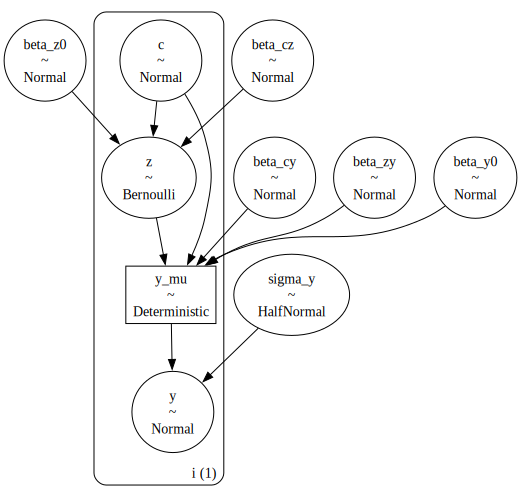

In [5]:
pm.model_to_graphviz(model_generative)

In [6]:
true_ATE = 0.0

true_values = {
    "beta_z0": 0.0,
    "beta_y0": 0.0,
    "beta_cz": 1.5,
    "beta_zy": true_ATE,
    "beta_cy": 1.0,
    "sigma_y": 0.2,
}

In [7]:
model_simulate = pm.do(model_generative, true_values)

In [8]:
N = 100

with model_simulate:
    simulate = pm.sample_prior_predictive(samples=N, random_seed=rng)

observed = {
    "c": simulate.prior["c"].values.flatten(),
    "y": simulate.prior["y"].values.flatten(),
    "z": simulate.prior["z"].values.flatten(),
}

Sampling: [c, y, z]


In [9]:
df = pd.DataFrame(observed).sort_values("c", ascending=False)
df.head()

,c,y,z
64,2.000056,2.323175,1
83,1.867227,1.820430,1
90,1.846210,1.847524,1
98,1.789933,1.658561,1
56,1.780733,1.993990,1


In [10]:
df.shape

(100, 3)

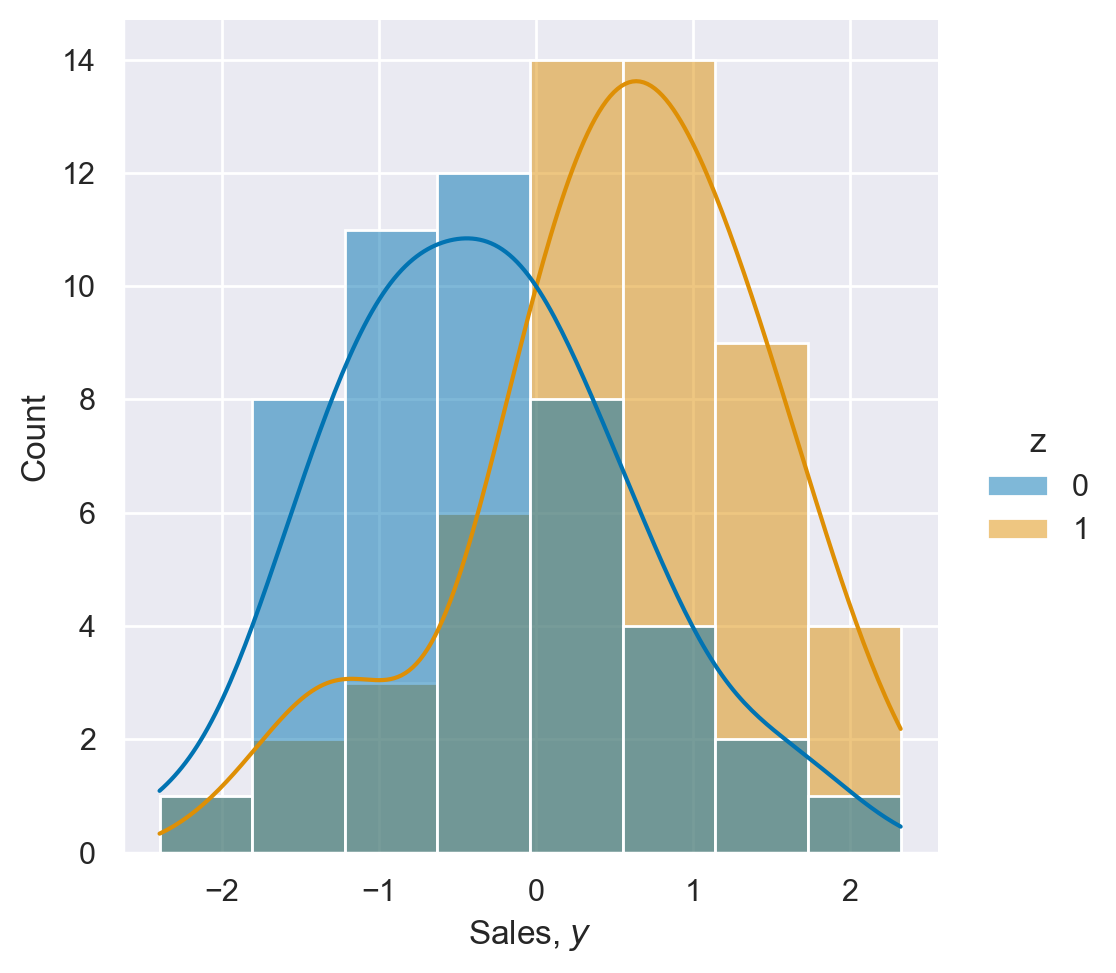

In [11]:
ax = sns.displot(data=df, x="y", hue="z", kde=True)
_ = ax.set(xlabel="Sales, $y$")

In [12]:
model_bambi = bmb.Model("y ~ z", df)
idata_bambi = model_bambi.fit(method="nuts_numpyro")

Compiling...


Compilation time = 0:00:01.253784


Sampling...


  0%|                                                                                  | 0/2000 [00:00<?, ?it/s]

Compiling.. :   0%|                                                                    | 0/2000 [00:00<?, ?it/s]

  0%|                                                                                  | 0/2000 [00:00<?, ?it/s]

Compiling.. :   0%|                                                                    | 0/2000 [00:00<?, ?it/s]

  0%|                                                                                  | 0/2000 [00:00<?, ?it/s]

Compiling.. :   0%|                                                                    | 0/2000 [00:00<?, ?it/s]

  0%|                                                                                  | 0/2000 [00:00<?, ?it/s]

Compiling.. :   0%|                                                                    | 0/2000 [00:00<?, ?it/s]

Running chain 2:   0%|                                                                 | 0/2000 [00:01<?, ?it/s]

Running chain 1:   0%|                                                                 | 0/2000 [00:01<?, ?it/s]

Running chain 3:   0%|                                                                 | 0/2000 [00:01<?, ?it/s]

Running chain 0:   0%|                                                                 | 0/2000 [00:01<?, ?it/s]

Running chain 0: 100%|████████████████████████████████████████████████████| 2000/2000 [00:01<00:00, 1449.87it/s]


Running chain 1: 100%|████████████████████████████████████████████████████| 2000/2000 [00:01<00:00, 1451.18it/s]


Running chain 2: 100%|████████████████████████████████████████████████████| 2000/2000 [00:01<00:00, 1452.55it/s]


Running chain 3: 100%|████████████████████████████████████████████████████| 2000/2000 [00:01<00:00, 1453.83it/s]


Sampling time = 0:00:01.597576


Transforming variables...


Transformation time = 0:00:00.063527


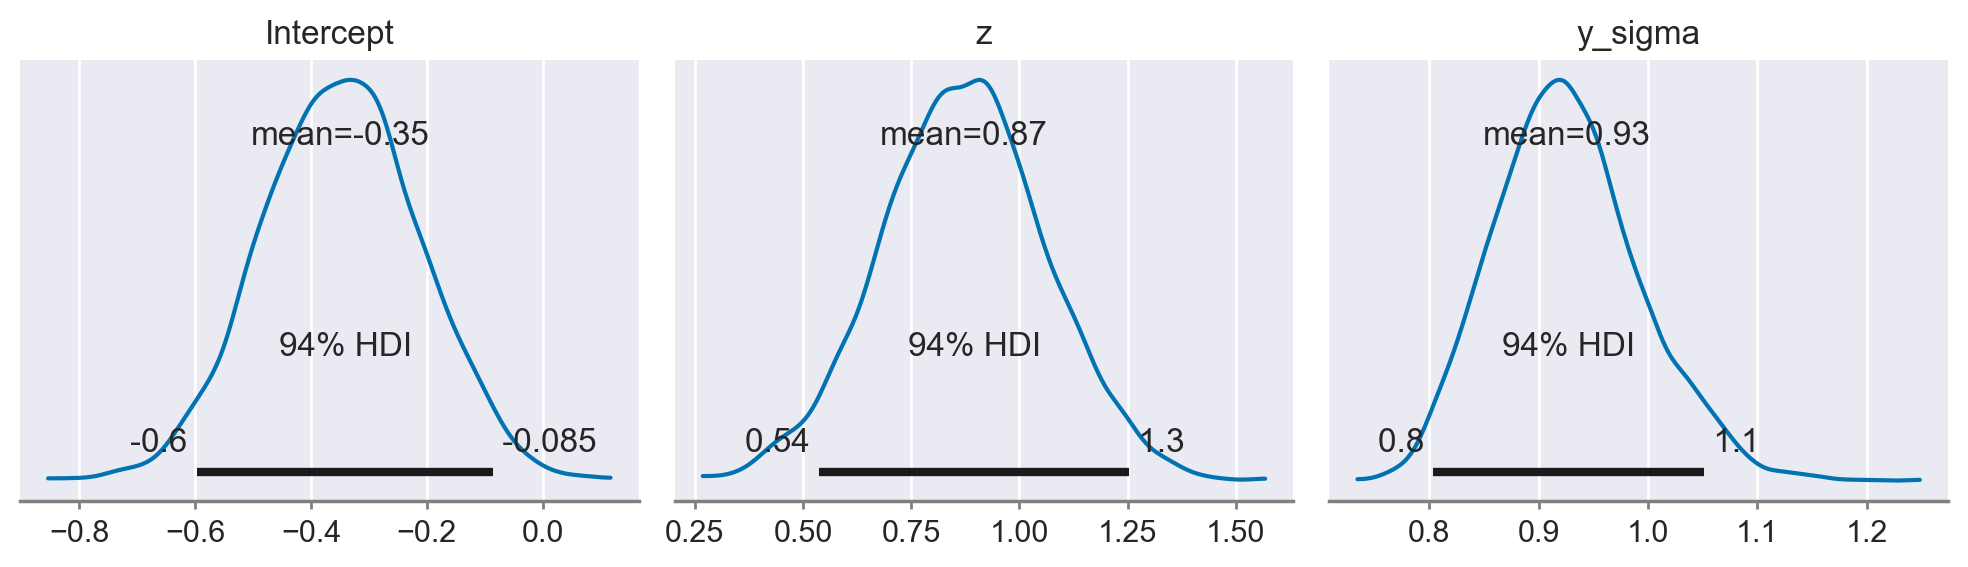

In [13]:
az.plot_posterior(
    idata_bambi,
    figsize=(10, 3),
)
plt.tight_layout();

In [14]:
model_inference = pm.observe(model_generative, {"c": df["c"], "y": df["y"], "z": df["z"]})
model_inference.set_dim("i", N, coord_values=np.arange(N))

In [15]:
with model_inference:
    idata = pm.sampling_jax.sample_numpyro_nuts(random_seed=rng)

Compiling...


Compilation time = 0:00:00.831526


Sampling...


  0%|                                                                                  | 0/2000 [00:00<?, ?it/s]

Compiling.. :   0%|                                                                    | 0/2000 [00:00<?, ?it/s]

  0%|                                                                                  | 0/2000 [00:00<?, ?it/s]

Compiling.. :   0%|                                                                    | 0/2000 [00:00<?, ?it/s]

  0%|                                                                                  | 0/2000 [00:00<?, ?it/s]

Compiling.. :   0%|                                                                    | 0/2000 [00:00<?, ?it/s]

  0%|                                                                                  | 0/2000 [00:00<?, ?it/s]

Compiling.. :   0%|                                                                    | 0/2000 [00:00<?, ?it/s]

Running chain 1:   0%|                                                                 | 0/2000 [00:01<?, ?it/s]

Running chain 0:   0%|                                                                 | 0/2000 [00:01<?, ?it/s]

Running chain 2:   0%|                                                                 | 0/2000 [00:01<?, ?it/s]

Running chain 3:   0%|                                                                 | 0/2000 [00:01<?, ?it/s]

Running chain 0: 100%|████████████████████████████████████████████████████| 2000/2000 [00:01<00:00, 1171.98it/s]


Running chain 1: 100%|████████████████████████████████████████████████████| 2000/2000 [00:01<00:00, 1172.54it/s]


Running chain 2: 100%|████████████████████████████████████████████████████| 2000/2000 [00:01<00:00, 1173.40it/s]


Running chain 3: 100%|████████████████████████████████████████████████████| 2000/2000 [00:01<00:00, 1174.28it/s]


Sampling time = 0:00:01.891815


Transforming variables...


Transformation time = 0:00:00.090735


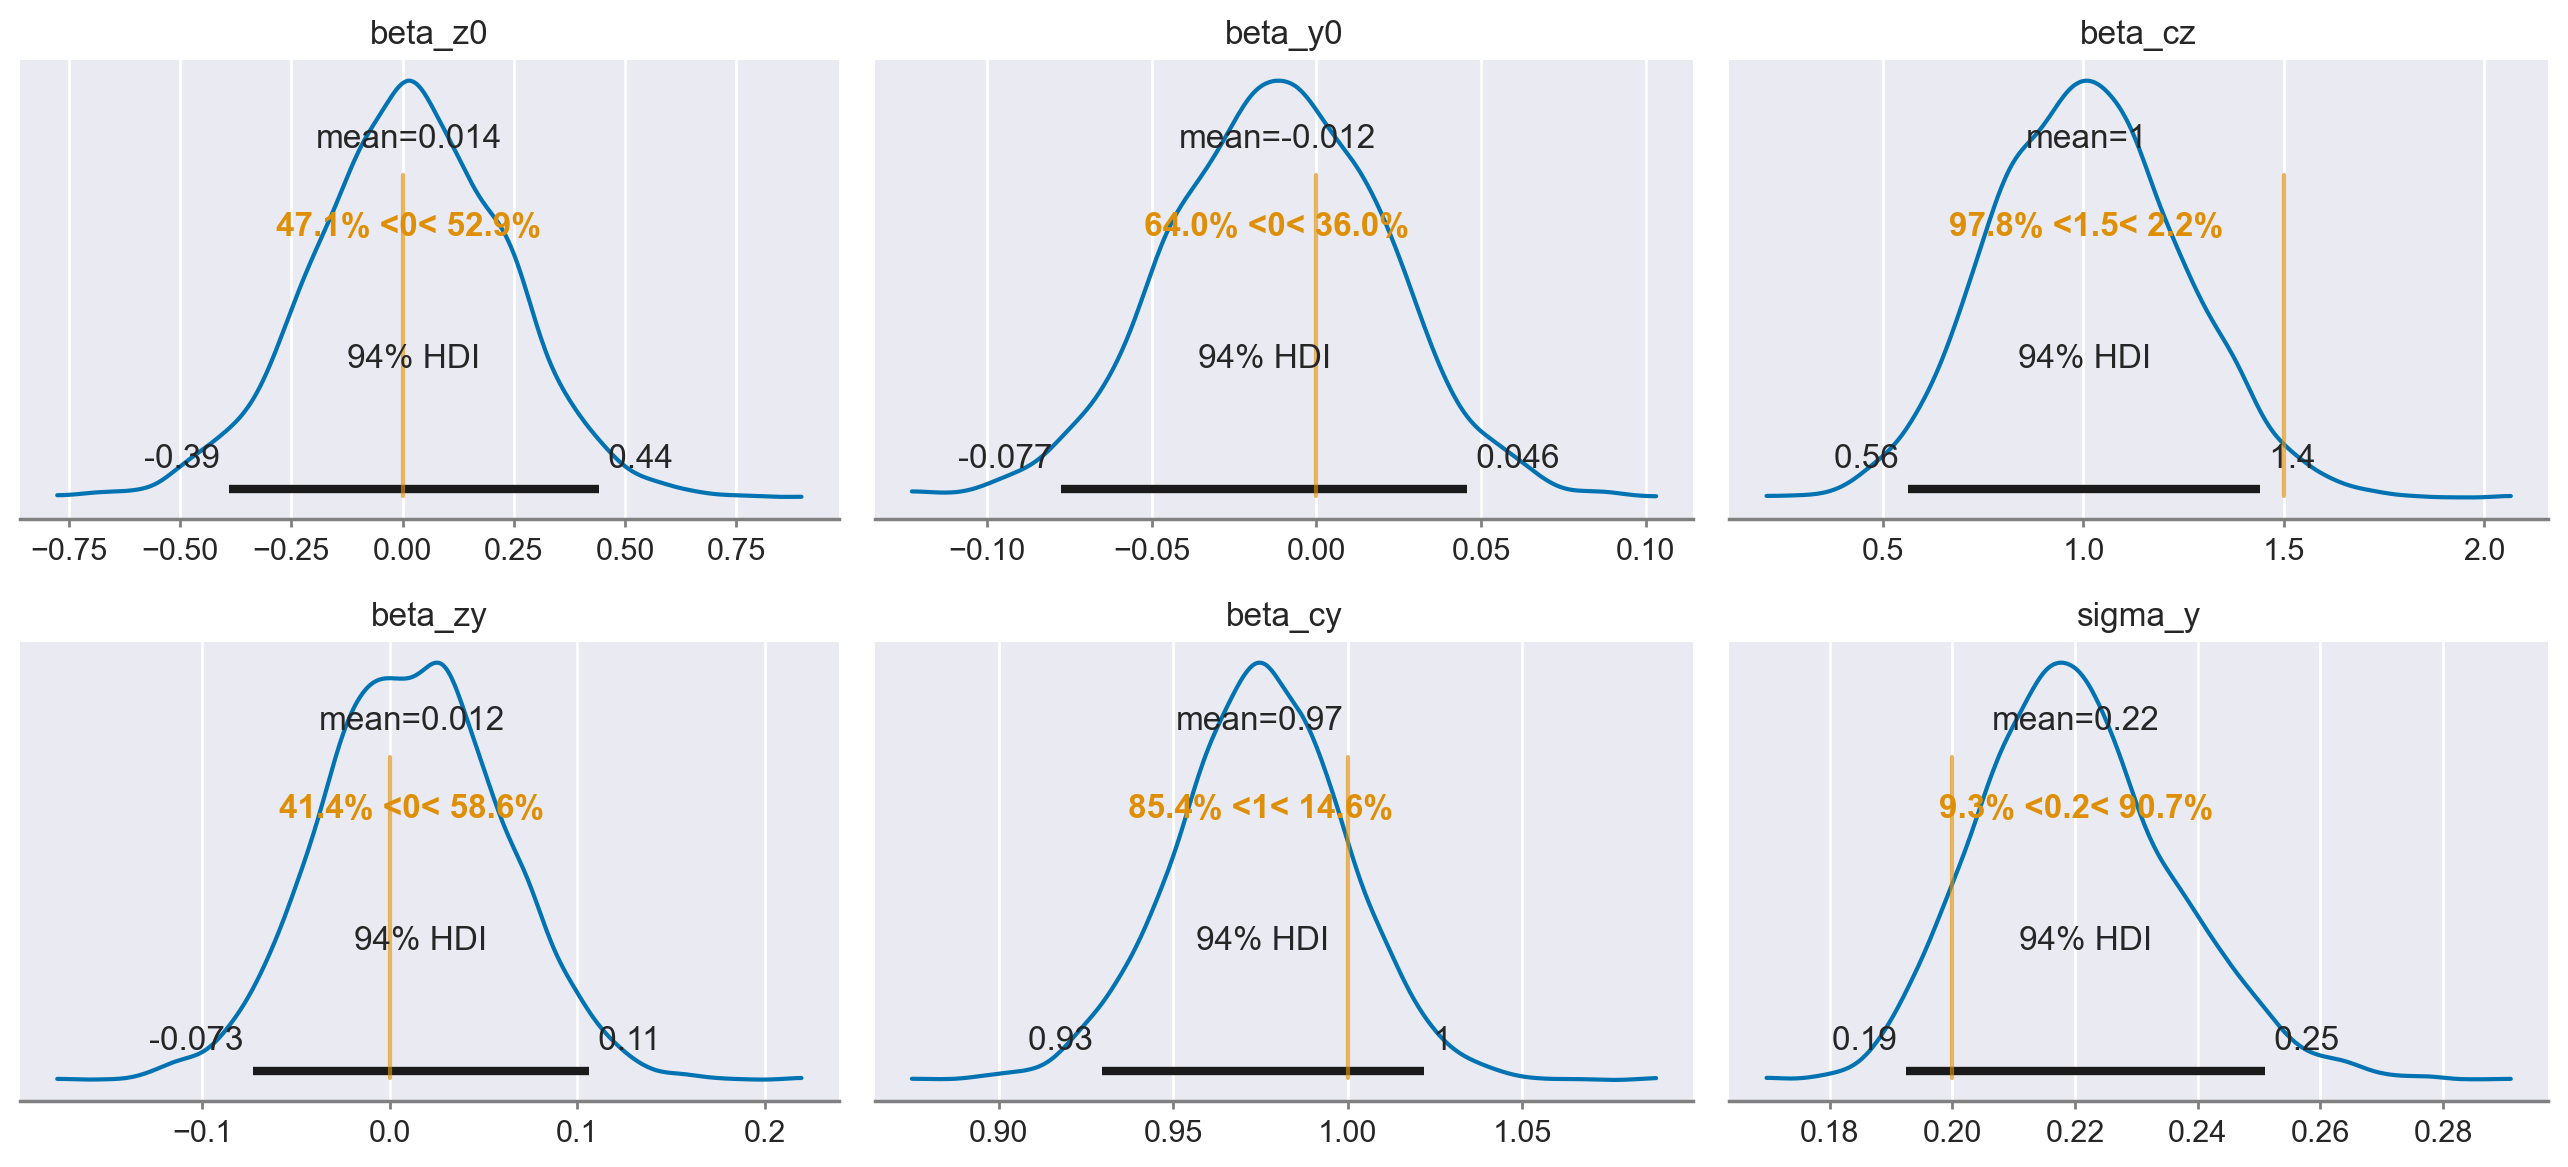

In [16]:
az.plot_posterior(
    idata,
    var_names=list(true_values.keys()),
    ref_val=list(true_values.values()),
    figsize=(13, 6),
)
plt.tight_layout();

In [17]:
# Replace c with its observed values
model_counterfactual = pm.do(model_inference, {"c": df["c"]})

In [18]:
# Generate models with Z=0 and Z=1
model_z0 = pm.do(model_counterfactual, {"z": np.zeros(N, dtype="int32")}, prune_vars=True)
model_z1 = pm.do(model_counterfactual, {"z": np.ones(N, dtype="int32")}, prune_vars=True)

In [19]:
# Sample well-being data assuming mindfulness off: P(Y | c, do(z=0))
idata_z0 = pm.sample_posterior_predictive(
    idata,
    model=model_z0,
    predictions=True,
    var_names=["y_mu"],
    random_seed=rng,
)
# Sample well-being data assuming mindfulness on: P(Y | c, do(z=1))
idata_z1 = pm.sample_posterior_predictive(
    idata,
    model=model_z1,
    predictions=True,
    var_names=["y_mu"],
    random_seed=rng,
)

Sampling: []


Sampling: []


In [20]:
# calculate estimated ATE
ATE_est = idata_z1.predictions - idata_z0.predictions
print(f"Estimated ATE = {ATE_est.y_mu.mean().values:.2f}")

Estimated ATE = 0.01


In [21]:
def plot_causal_estimates(models, ATE_est, model_names):
    """Utility plot function to generate figure for estimated outcomes and causal effects."""
    fig, ax = plt.subplots(1, 2)

    # left plot of estimated outcomes
    ret = az.plot_forest(
        [models[0].predictions, models[1].predictions],
        combined=True,
        ax=ax[0],
        model_names=model_names,
    )
    # remove alternate row shading
    for p in ret[0].patches:
        p.set_color("white")

    # right plot of estimated ATE
    az.plot_posterior(
        idata, var_names="beta_zy", ref_val=true_ATE, round_to=4, ax=ax[1]
    )

    # formatting
    ax[0].set(
        title="Estimated outcomes under intervention",
        ylabel="unit, $i$ (ordered)",
        yticklabels=[],
    )
    ax[1].set(title="Average Treatment Effect")
    plt.tight_layout()

    plt.suptitle(
        "Unit level estimates with do operation,\nand estimate of Average Treatment Effect",
        y=1.05,
    );

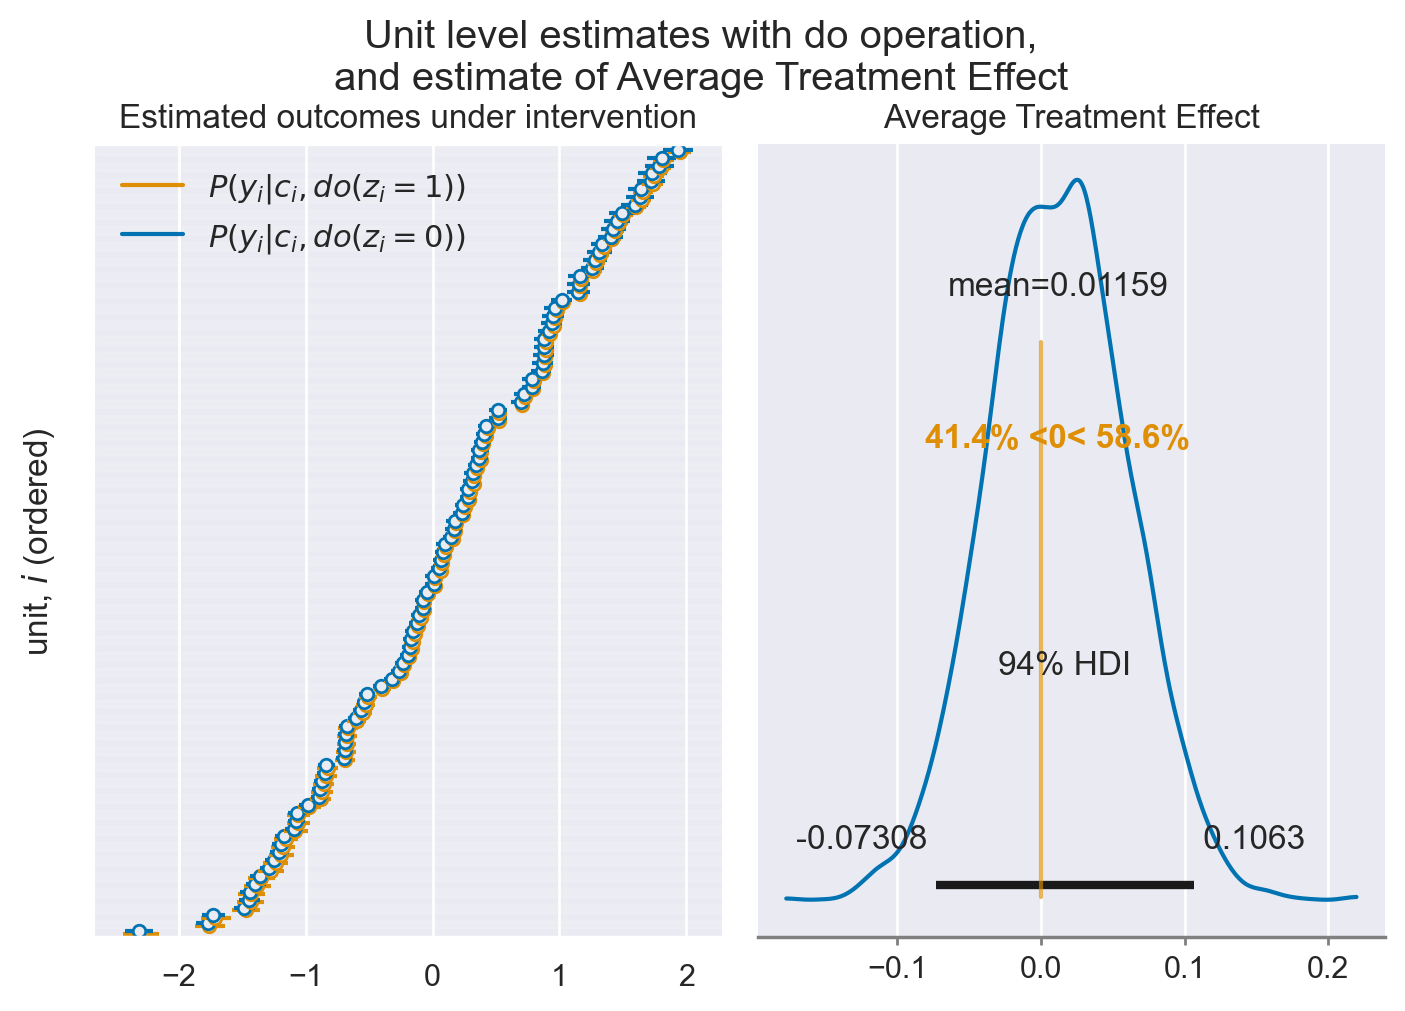

In [22]:
plot_causal_estimates(
    [idata_z0, idata_z1],
    ATE_est,
    model_names=[r"$P(y_i|c_i,do(z_i=0))$", r"$P(y_i|c_i,do(z_i=1))$"],
)

In [23]:
percent = (idata.posterior["beta_zy"] / idata.posterior["beta_cy"]) * 100
print(
    f"Causal effect of the TCC treatment on QoL is {percent.mean():.1f}% [{az.hdi(percent).x.data[0]:.1f}%,{az.hdi(percent).x.data[1]:.1f}%] of the effect of mindfulness on QoL"
)

Causal effect of the TCC treatment on QoL is 1.2% [-7.5%,10.9%] of the effect of mindfulness on QoL


In [24]:
%run ../wtrmrk.py

Watermark:
----------
Last updated: 2024-01-26T18:48:43.448440+01:00

Python implementation: CPython
Python version       : 3.11.7
IPython version      : 8.19.0

Compiler    : Clang 16.0.6 
OS          : Darwin
Release     : 23.3.0
Machine     : x86_64
Processor   : i386
CPU cores   : 8
Architecture: 64bit


